This file is used to generate the configuration files for Normal simulation.  
The configuration file should include a header. Each of the remaining lines should contain 14 parameters:  
- mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda: the hyperparameters of the prior of the topic parameters: $\lambda \sim Gamma(alpha\_Lambda, beta\_Lambda), \mu \sim N(mu\_Mu, sigma2_Mu/\lambda)$
- d: dimension of data.
- k0, k1: the number of class-specific topics and the number of shared topics.
- nlabel: the number of class.
- ntrace, nchain, nskip: the parameter for sampling.
- Ntrain, Ntest: the size of the training set and test set.
- Nfold: the number of folds in CV.

the value of a: 7.761086651040642
the value of rho: [0.17883955 0.46770863 0.15693047 0.19652135]


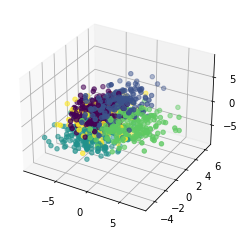

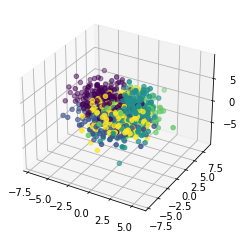

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

def document_generator(a, rho, T, Lambda, Tau, N):
    nlabel = len(T) # number of classes
    d = len(Tau[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)), N) # labels
    G = np.random.dirichlet(a*rho, N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = np.zeros((N, d))
    for i in range(N):
        u = U[i]
        for j in range(d):
            lambdax = np.dot(u, Lambda[:, j])
            taux = np.dot(u, Tau[:, j])
            sx = 1/lambdax
            mux = sx*taux
            X[i][j] = np.random.normal(mux, np.sqrt(sx))

    return X, Y, G, U

mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0,5,2,4
N = 1000
d = 20
k0, k1 = 2, 2
nlabel = 5


dg = k0 + k1 
K = ntopic = nlabel*k0+k1

alpha = np.ones(dg)
b = 0.1

# define T
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)


# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]
Lambda = np.random.gamma(shape = alpha_Lambda, scale = 1/beta_Lambda, size = (K,d))
Mu = np.random.normal(mu_Mu, np.sqrt(sigma2_Mu/Lambda), (K,d))
Tau = Mu * Lambda

print("the value of a:", a)
print("the value of rho:", rho)

X, Y, G, U = document_generator(a, rho, T, Lambda, Tau, N)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2],c=Y)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,4],X[:,7],X[:,9],c=Y)
plt.show()

In [26]:
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0,5,2,4
Lambda = np.random.gamma(shape = alpha_Lambda, scale = 1/beta_Lambda, size = 1000)
print(Lambda.mean())
S=1/Lambda
print(S.mean())
Mu = np.random.normal(mu_Mu, np.sqrt(sigma2_Mu/Lambda), 1000)
print(Mu.mean())
print(Mu.var())


0.5036226534982192
4.008238815010471
-0.009619021787107286
19.583151585049812


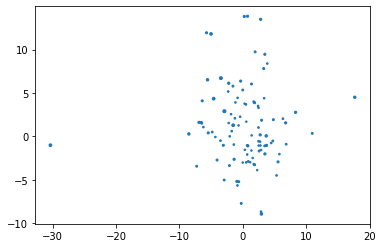

In [27]:
import math
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0,5,2,4
N = 100
Lambda1 = np.random.gamma(shape = alpha_Lambda, scale = 1/beta_Lambda, size = N)
Lambda2 = np.random.gamma(shape = alpha_Lambda, scale = 1/beta_Lambda, size = N)
Mu1 = np.random.normal(mu_Mu, np.sqrt(sigma2_Mu/Lambda1), N)
Mu2 = np.random.normal(mu_Mu, np.sqrt(sigma2_Mu/Lambda2), N)
S1 = np.sqrt(1/Lambda1)
S2 = np.sqrt(1/Lambda2)

# x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# y = np.array([1, 4, 9, 16, 7, 11, 23, 18])

# plt.scatter(x, y)
# plt.show()


plt.scatter(Mu1, Mu2, s=(S1+S2)/1)
plt.show()

## test case

In [28]:
# This file is used for test code correctness
header = "mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold"
para = [] 
ntrace = 100
nchain = 1
nskip = 2
Ntrain = 50
Ntest = 10
Nfold = 5

k0, k1 = 2, 5
d = 20
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0, 5, 2, 4
for nlabel in [2,4]:
    para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 

with open("configurations_test.csv", "w") as f:
    f.write(header)
    f.write("\n")
    for i in range(len(para)):
        tem = [str(char) for char in para[i]]
        f.write(",".join(tem))
        f.write("\n")



## Fix number of topics
- Fix k0 = 2, k1 = 5.
- Try d = 20, 40, 60, 80, 100.
- Increase nlabel from 2 to the max number that ensures K<=d. Stepsize = 2
- The number of replicas = 2.


In [31]:
header = "mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold"

para = [] 
# fixed parameters
ntrace = 1000
nchain = 2
nskip = 2
Ntrain = 500
Ntest = 100
Nfold = 5
k0, k1 = 2, 5
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0, 5, 2, 4

for d in [20, 40, 60, 80, 100]: # dimension
    max_nlabel = (d - k1)//k0
    for nlabel in range(2, max_nlabel+1, 2):
        para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 
        para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 
            
with open("configurations_fix_ntopic.csv", "w") as f:
    f.write(header)
    f.write("\n")
    for i in range(len(para)):
        tem = [str(char) for char in para[i]]
        f.write(",".join(tem))
        f.write("\n")            


## Fix dimension
- Fix d = 100.
- Fix alpha_p = (1, 1).
- Try k0, k1 = 2, 5, 10

In [30]:
header = "mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold"

para = [] 
# fixed parameters
ntrace = 1000
nchain = 2
nskip = 2
Ntrain = 500
Ntest = 100
Nfold = 5
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0, 5, 2, 4
d = 100

for k0 in [2, 5, 10]:
    for k1 in [2, 5, 10]:
        if (k0, k1) == (2, 5): continue
        max_nlabel = (d - k1)//k0
        for nlabel in range(2, max_nlabel+1, 2):
            para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 
            para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 
            
with open("configurations_d100.csv", "w") as f:
    f.write(header)
    f.write("\n")
    for i in range(len(para)):
        tem = [str(char) for char in para[i]]
        f.write(",".join(tem))
        f.write("\n")            

## random configurations

In [32]:
# random parameter
import numpy as np
import random

header = "mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold"

para = [] 

# fixed parameters
ntrace = 500
nchain = 2
nskip = 2
Ntrain = 200
Ntest = 100
Nfold = 5
mu_Mu = 0
for i in range(600):
    d = np.random.randint(low = 20, high = 200, size=1)[0]
    nlabel = np.random.randint(low = 2, high = 11, size=1)[0]
    
    max_k0 = (d-1)//nlabel
    k0 = np.random.randint(low = 1, high = max_k0+1, size=1)[0]
    k1 = np.random.randint(low = 1, high = d-k0*nlabel+1, size=1)[0]

    alpha_Lambda = np.random.uniform(1,10,1)[0]
    beta_Lambda = np.random.uniform(0,10,1)[0]
    sigma2_Mu = np.random.uniform(0,100,1)[0] * (alpha_Lambda - 1) / beta_Lambda
    
    para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest, Nfold]) 

with open("configurations_random.csv", "w") as f:
    f.write(header)
    f.write("\n")
    for i in range(len(para)):
        tem = [str(char) for char in para[i]]
        f.write(",".join(tem))
        f.write("\n")            

# Configurations to analyze membership

In [2]:
import numpy as np
header = "mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, set_index, d, k0, k1, k0_train, k1_train, nlabel, ntrace, nchain, nskip, Ntrain, Ntest"
header2 = "set_index, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest" # this configuration file only save the configurations for true model

para = [] 
para2 = []
# fixed parameter
ntrace = 1000
nchain = 2
nskip = 2
Ntrain = 300
Ntest = 100
mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda = 0, 5, 2, 4

set_index = 0
for d in [20,50,100]:
    for nlabel in [3, 6, 9]:
        for k0 in [2, 5, 10]:
            for k1 in [2, 5, 10]:
                set_index += 1

                para2.append([set_index, d, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest]) 
        

                if k0 != k1:
                    # true k0, k1
                    para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, set_index, d, k0, k1, k0, k1, nlabel, ntrace, nchain, nskip, Ntrain, Ntest]) 
        
                for train_k in [2, 5, 10]:
                    para.append([mu_Mu, sigma2_Mu, alpha_Lambda, beta_Lambda, set_index, d, k0, k1, train_k, train_k, nlabel, ntrace, nchain, nskip, Ntrain, Ntest]) 

with open("configurations_membership.csv", "w") as f:
    f.write(header)
    f.write("\n")
    for i in range(len(para)):
        tem = [str(char) for char in para[i]]
        f.write(",".join(tem))
        f.write("\n")         

with open("configurations_membership_dataset.csv", "w") as f:
    f.write(header2)
    f.write("\n")
    for i in range(len(para2)):
        tem = [str(char) for char in para2[i]]
        f.write(",".join(tem))
        f.write("\n")        


        

